## Reachability, Burstiness and Motifs in Graphs:

There is a datafile attached to this exercise which can also be found at its source:

https://snap.stanford.edu/data/email-Eu-core-temporal.html

This is a temporal data, the file has three columns separated by space, the first is the id of the sender, the second is the id of the receiver, the third is a timestamp. All exercises involve recreating graphs from lecture 6, and I will refer to slide numbers of the uploaded pdf.

1.)

Recreate the reachability curves on pages 41-46. Start from a random node. Pass an information if there is an event from an information holder to another agent. Repeat the experiment few dozen times with different sources and plot the average

• repeat the above with time shuffling. Here randomly shuffle the third column

• repeat the above with link shuffling. Take two links: A->B, C->D, shuffle it to A->D, C->B. In other words shuffle the second column

• repeat the above experiment with both shufflings

2.)

Measure the interevent time distribution and the burstiness. Here interevent time is defined as the time interval between two actions by the same agent

3.)

Choose 6 different motifs both causal and non-causal ones in the original and the time shuffled version. Compare the relative frequencies for at least 3 different time window

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from collections import Counter
from itertools import combinations

## Network Visualisation

In [ ]:
file_name = 'email-Eu-core-temporal-Dept3.txt'

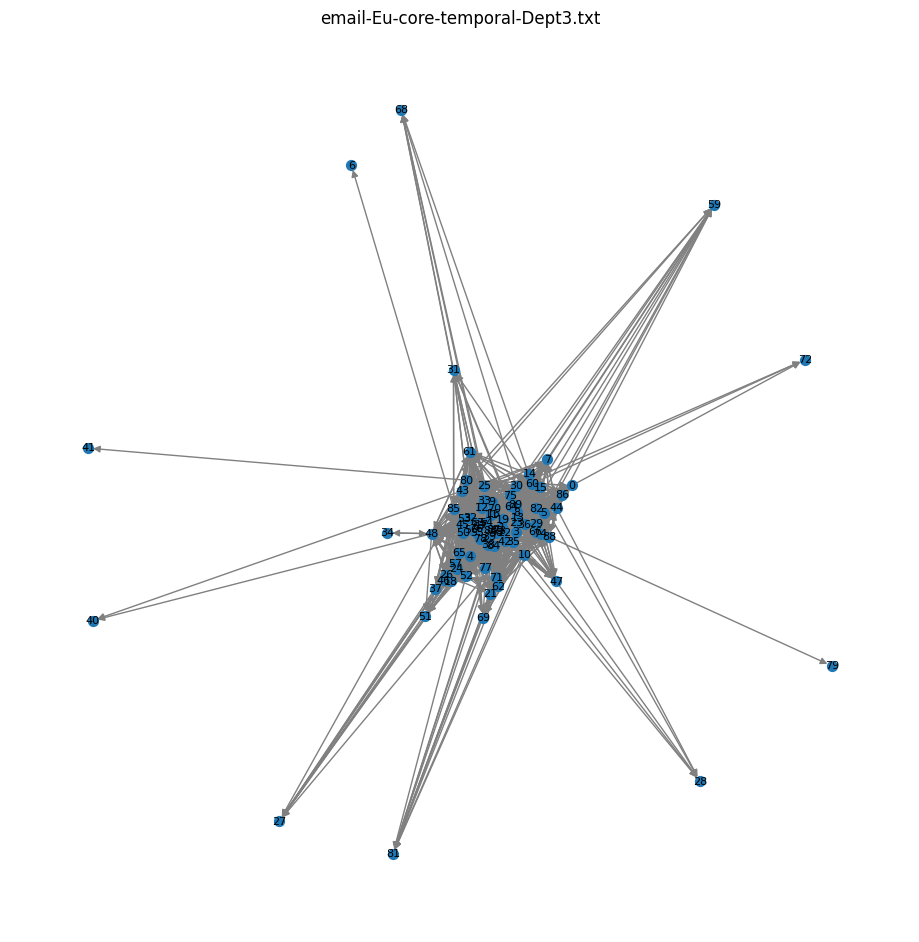

In [ ]:
# Initialize a directed graph
Graph = nx.DiGraph()

# Read the file and add edges to the graph
with open(file_name, 'r') as f:
    for line in f:
        sender, receiver, timestamp = map(int, line.split())
        Graph.add_edge(sender, receiver, timestamp=timestamp)

# Draw the graph
plt.figure(figsize=(9, 9))
pos = nx.spring_layout(Graph, seed=42)  # Positions for all nodes
nx.draw(Graph, pos, node_size=50, with_labels=True, font_size=8, edge_color='gray')
plt.title(file_name)
plt.show()

## Reachability Curves


100%|██████████| 64/64 [03:18<00:00,  3.10s/it]


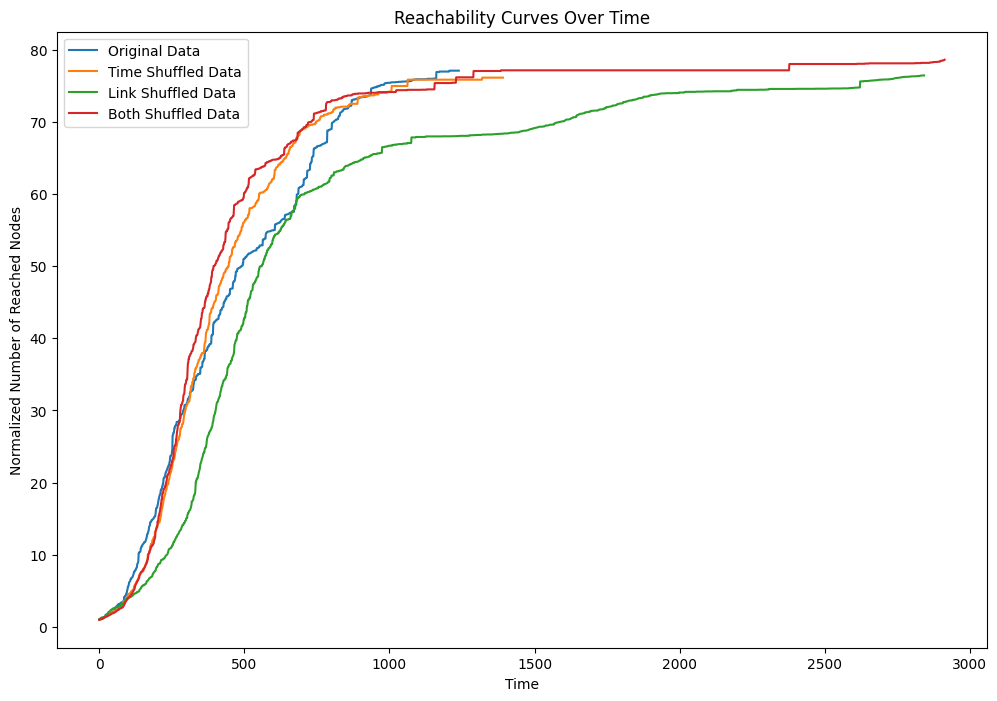

In [ ]:
# Load data
data = pd.read_csv(file_name, sep=' ', header=None, names=['sender', 'receiver', 'timestamp'])

# Create directed graph from data
def create_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        G.add_edge(row['sender'], row['receiver'], timestamp=row['timestamp'])
    return G

# Simulate reachability using provided approach
def simulate_reachability(G, start_node):
    timestamps = sorted(set(nx.get_edge_attributes(G, 'timestamp').values()))
    reached_nodes = set([start_node])
    reachability = []

    for t in timestamps:
        new_nodes = set()
        for u, v, data in G.edges(data=True):
            if data['timestamp'] == t and u in reached_nodes and v not in reached_nodes:
                new_nodes.add(v)
        reached_nodes.update(new_nodes)
        reachability.append(len(reached_nodes))

    return reachability

# Function to shuffle timestamps
def shuffle_timestamps(data):
    shuffled_data = data.copy()
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)

    return shuffled_data

# Function to shuffle receivers
def shuffle_receivers(data):
    shuffled_data = data.copy()
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)

    return shuffled_data

# Function to shuffle both timestamps and receivers
def shuffle_both(data):
    shuffled_data = data.copy()
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)
    shuffled_data['receiver'] = np.random.permutation(shuffled_data['receiver'].values)

    return shuffled_data

# Average reachability over multiple simulations
def average_reachability(G, iterations=64):
    num_nodes = G.number_of_nodes()
    all_reachabilities = []

    for _ in tqdm(range(iterations)):
        start_node = random.choice(list(G.nodes))
        reachability = simulate_reachability(G, start_node)
        all_reachabilities.append(reachability)

    max_length = max(len(r) for r in all_reachabilities)
    avg_reachability = np.zeros(max_length)

    for reachability in all_reachabilities:
        reachability += [reachability[-1]] * (max_length - len(reachability))  # Extend to max_length
        avg_reachability += reachability

    avg_reachability /= iterations
    return avg_reachability

# Prepare original and shuffled graphs
G_original = create_graph(data)
G_time_shuffled = create_graph(shuffle_timestamps(data))
G_link_shuffled = create_graph(shuffle_receivers(data))
G_both_shuffled = create_graph(shuffle_both(data))

# Simulate and average reachability
original_reachability = average_reachability(G_original)
time_shuffled_reachability = average_reachability(G_time_shuffled)
link_shuffled_reachability = average_reachability(G_link_shuffled)
both_shuffled_reachability = average_reachability(G_both_shuffled)

# Plotting the reachability curves over time
plt.figure(figsize=(12, 8))
plt.plot(original_reachability, label='Original Data')
plt.plot(time_shuffled_reachability, label='Time Shuffled Data')
plt.plot(link_shuffled_reachability, label='Link Shuffled Data')
plt.plot(both_shuffled_reachability, label='Both Shuffled Data')
plt.xlabel('Time')
plt.ylabel('Normalized Number of Reached Nodes')
plt.title('Reachability Curves Over Time')
plt.legend()
plt.show()



## Interevent Time

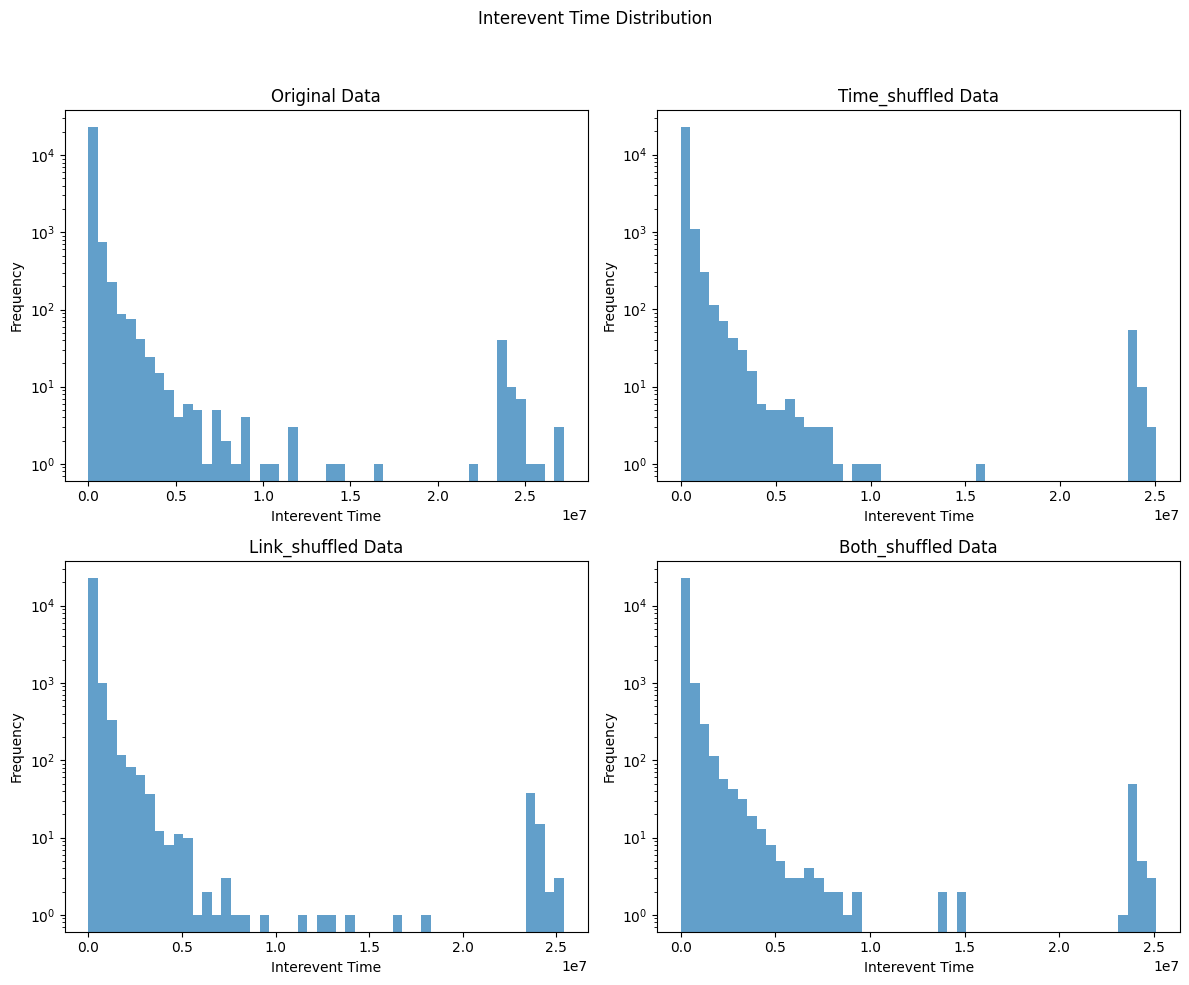

In [ ]:
# Function to calculate interevent times for each agent
def calculate_interevent_times(data):
    interevent_times = {}

    # Concatenate sender and receiver columns for both directions of communication
    all_timestamps = pd.concat([data[['sender', 'timestamp']].rename(columns={'sender': 'agent'}),
                                data[['receiver', 'timestamp']].rename(columns={'receiver': 'agent'})])

    for agent in all_timestamps['agent'].unique():
        timestamps = all_timestamps[all_timestamps['agent'] == agent]['timestamp'].sort_values().values
        if len(timestamps) > 1:
            intervals = np.diff(timestamps)
            interevent_times[agent] = intervals

    return interevent_times

# Function to calculate burstiness
def calculate_burstiness(interevent_times):
    burstiness = {}

    for agent, intervals in interevent_times.items():
        mean = np.mean(intervals)
        std = np.std(intervals)
        if mean + std != 0:
            burstiness[agent] = (std - mean) / (std + mean)

    return burstiness

# Calculate interevent times and burstiness for different versions of data
def process_data_versions(data, shuffle_funcs):
    results = {}

    for name, shuffle_func in shuffle_funcs.items():
        shuffled_data = shuffle_func(data)
        interevent_times = calculate_interevent_times(shuffled_data)
        burstiness = calculate_burstiness(interevent_times)
        results[name] = {
            'interevent_times': interevent_times,
            'burstiness': burstiness
        }

    return results

# Shuffle functions for different data versions
shuffle_funcs = {
    'original': lambda x: x,
    'time_shuffled': shuffle_timestamps,
    'link_shuffled': shuffle_receivers,
    'both_shuffled': shuffle_both
}

# Process data
results = process_data_versions(data, shuffle_funcs)

# Plot interevent time distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
for i, (name, result) in enumerate(results.items()):
    all_interevent_times = np.concatenate(list(result['interevent_times'].values()))
    axs[i].hist(all_interevent_times, bins=50, log=True, alpha=0.7)
    axs[i].set_title(f'{name.capitalize()} Data')
    axs[i].set_xlabel('Interevent Time')
    axs[i].set_ylabel('Frequency')

fig.suptitle('Interevent Time Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Burstiness

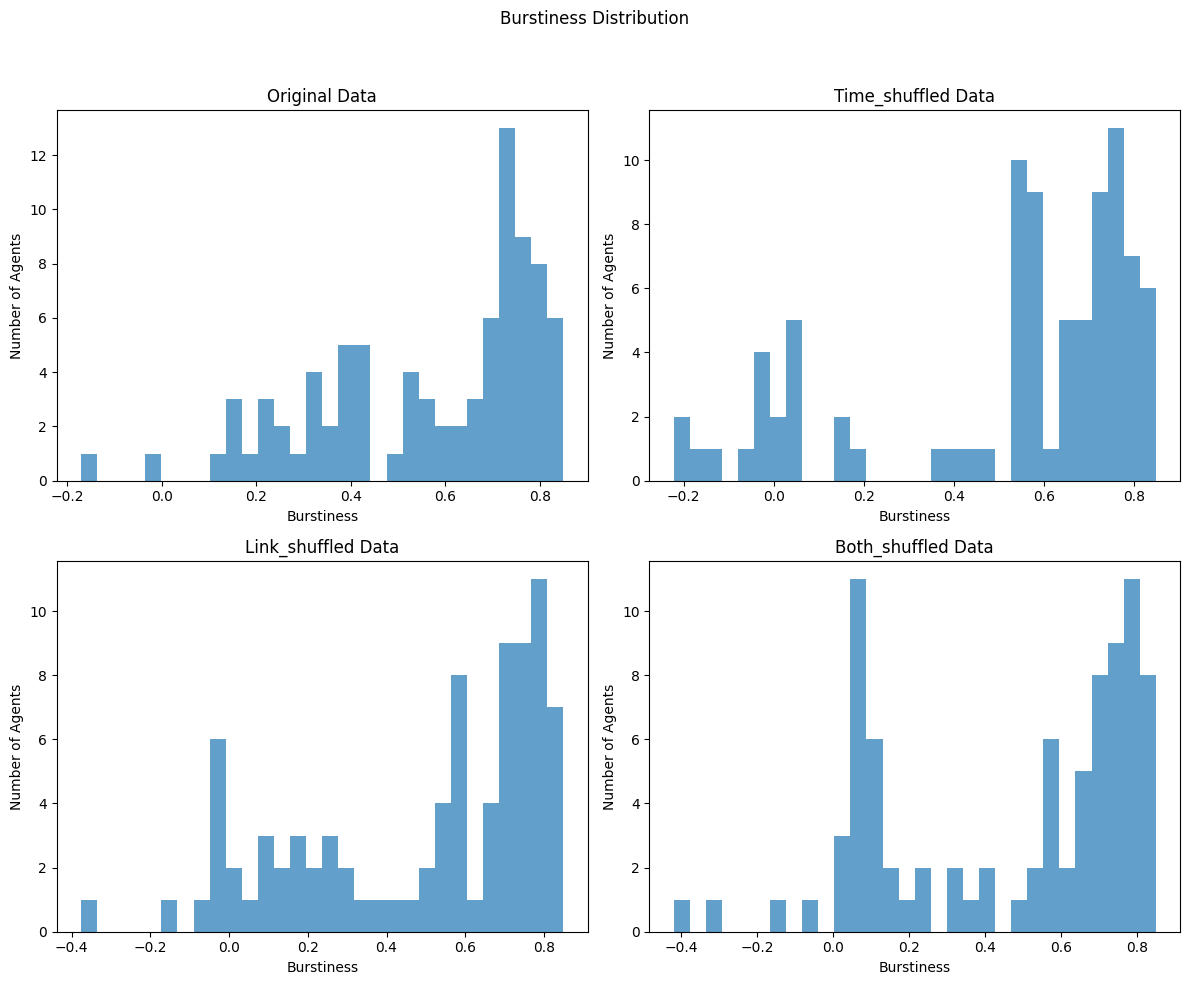

In [ ]:
# Plot burstiness distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
for i, (name, result) in enumerate(results.items()):
    axs[i].hist(result['burstiness'].values(), bins=30, alpha=0.7)
    axs[i].set_title(f'{name.capitalize()} Data')
    axs[i].set_xlabel('Burstiness')
    axs[i].set_ylabel('Number of Agents')

fig.suptitle('Burstiness Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Motifs

Causal Motifs:

M1: A -> B -> C

M2: A -> B -> A

M3: A -> B, B -> C

Non-Causal Motifs:

M4: A -> B, C -> B

M5: A -> B, C -> A

M6: A -> B, B -> C, C -> A

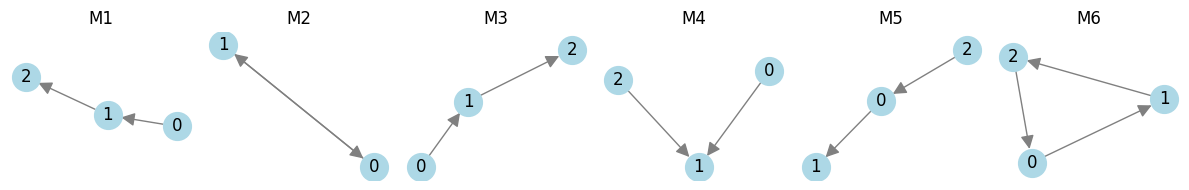

In [ ]:
# Define motifs
motifs = {
    'M1': [(0, 1), (1, 2)],  # A -> B -> C
    'M2': [(0, 1), (1, 0)],  # A -> B -> A
    'M3': [(0, 1), (1, 2)],  # A -> B, B -> C
    'M4': [(0, 1), (2, 1)],  # A -> B, C -> B
    'M5': [(0, 1), (2, 0)],  # A -> B, C -> A
    'M6': [(0, 1), (1, 2), (2, 0)]  # A -> B, B -> C, C -> A
}

# Function to draw all motifs in a single row
def draw_all_motifs_in_row(motifs):
    num_motifs = len(motifs)
    fig, axs = plt.subplots(1, num_motifs, figsize=(num_motifs * 2, 2), sharey=True)

    for ax, (motif_name, edges) in zip(axs, motifs.items()):
        G = nx.DiGraph()
        G.add_edges_from(edges)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=400, arrowsize=20)
        ax.set_title(motif_name, fontsize=12)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Draw all motifs in a single row
draw_all_motifs_in_row(motifs)

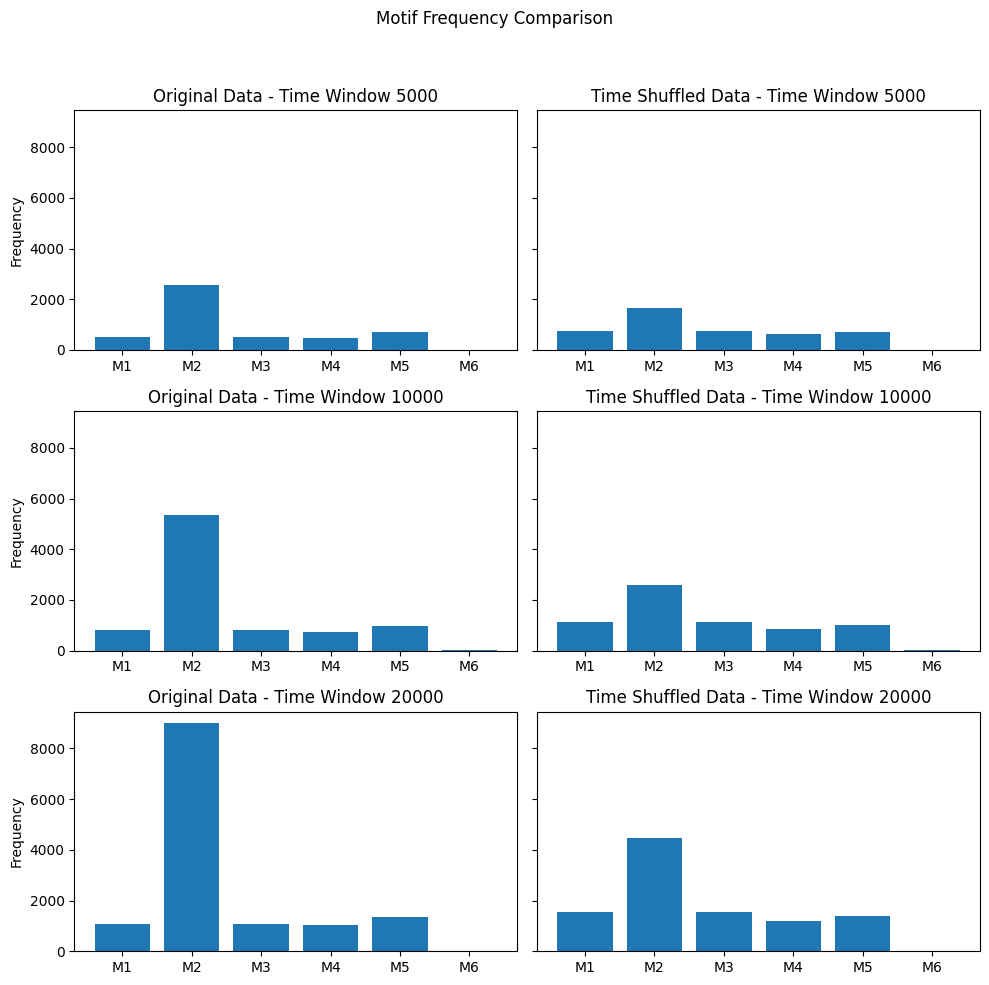

In [ ]:
# Function to shuffle timestamps
def shuffle_timestamps(data):
    shuffled_data = data.copy()
    shuffled_data['timestamp'] = np.random.permutation(shuffled_data['timestamp'].values)
    return shuffled_data

# Function to detect motifs in a time window
def detect_motifs(data, time_window, motifs):
    time_windows = data.groupby(data['timestamp'] // time_window)
    motif_counts = Counter()

    for _, window in time_windows:
        G = nx.DiGraph()
        for _, row in window.iterrows():
            G.add_edge(row['sender'], row['receiver'])

        for motif, edges in motifs.items():
            count = 0
            nodes_combinations = combinations(G.nodes, 3)
            for nodes in nodes_combinations:
                subgraph = G.subgraph(nodes)
                edges_present = [(u, v) for u, v in edges if subgraph.has_edge(nodes[u], nodes[v])]
                if len(edges_present) == len(edges):
                    count += 1
            motif_counts[motif] += count

    return motif_counts

# Time windows to analyze
time_windows = [5000, 10000, 20000]

# Shuffle timestamps for the time shuffled version
data_shuffled = shuffle_timestamps(data)

# Detect motifs for each time window
results_original = {tw: detect_motifs(data, tw, motifs) for tw in time_windows}
results_shuffled = {tw: detect_motifs(data_shuffled, tw, motifs) for tw in time_windows}

# Plotting the results
fig, axs = plt.subplots(len(time_windows), 2, figsize=(10, 10), sharey=True)
for i, tw in enumerate(time_windows):
    # Original Data
    motif_counts_original = results_original[tw]
    axs[i, 0].bar(motif_counts_original.keys(), motif_counts_original.values())
    axs[i, 0].set_title(f'Original Data - Time Window {tw}')
    axs[i, 0].set_ylabel('Frequency')

    # Shuffled Data
    motif_counts_shuffled = results_shuffled[tw]
    axs[i, 1].bar(motif_counts_shuffled.keys(), motif_counts_shuffled.values())
    axs[i, 1].set_title(f'Time Shuffled Data - Time Window {tw}')

fig.suptitle('Motif Frequency Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


I used Code Copilot, lecture notes and pages 395–420 from book "Hálozatok tudománya" from Barabasi